# **Change directory to the project folder in my drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! ls

gdrive	sample_data


In [ ]:
%cd /content/gdrive/My Drive/CV_Project/CV_Project

/content/gdrive/My Drive/CV_Project/CV_Project


#**Section 1 : Train an SSD object detector on a road traffic datasets created by Udacity**

##Preparing the packages

In [ ]:
%tensorflow_version 1.x
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


## Set the model configuration parameters

In [ ]:
#Height, width, channels of the input images
img_height = 300 
img_width = 480 
img_channels = 3 

# The current settings to transform the input pixel values to the interval `[-1,1]`.
intensity_mean = 127.5 
intensity_range = 127.5 

# Number of classes in the uploaded dataset
n_classes = 5 

# An explicit list of anchor box scaling factors. If this is passed, 
# it will override the `min_scale` and `max_scale` arguments.
scales = [0.08, 0.16, 0.32, 0.64, 0.96]

aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True #generate two anchor boxes for aspect ratio 1
steps = None # to set the step sizes for the anchor box grids manually; none to set it automaitcally
offsets = None # to set the offsets for the anchor box grids manually;
clip_boxes = False # this option to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # the model is supposed to use coordinates relative to the image size

## Build or load the model

###Create a new model (skip this section if you have already trained the model and have a saved one)

In [ ]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

#model.load_weights('./ssd7_weights.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


### Load a saved model

In [ ]:
model_path = 'ssd7_epoch-14_loss-2.1865_val_loss-1.5318.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})
model.summary()

## Set up the data generators for the training

### Note: (we can comment create_hdf5_dataset section if we have already prepared the data into .h files)

to train SSD7 we used two road traffic datasets released by [Udacity](https://github.com/udacity/self-driving-car/tree/master/annotations) with around 22,000 images in total and 5 object classes (car, truck, pedestrian, bicyclist, traffic light), although the vast majority of the objects are cars. The original datasets have a constant image size of 1200x1920 RGB. We resized the images to 300x480 RGB. I uploaded the dataset into my drive (about 900MB)

### Load the train and val datasets hdf5 files

Note: if we go for calculating the mAP so we can comment out loading the train dataset to save memory RAM


In [ ]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.
# DataGenerator provides loading the entire dataset into memory, 
# which reduces the access time for any image
# Another option is loading the HDF5 file that stores the images as uncompressed arrays in a contiguous block of memory, 
# which dramatically speeds up the loading time.

# if we go for calculating the mAP so we can comment out loading the train dataset to save ram memory

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='dataset_traffic_train.h5')
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='dataset_traffic_val.h5')

# 2: Parse the image and label lists for the training and validation datasets.

# Images
images_dir = 'udacity_driving_datasets'

# Ground truth
train_labels_filename = 'labels_train.csv'
val_labels_filename   = 'labels_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

#train_dataset.create_hdf5_dataset(file_path='dataset_traffic_train.h5',
#                                  resize=False,
#                                  variable_image_size=True,
#                                  verbose=True)

#val_dataset.create_hdf5_dataset(file_path='dataset_traffic_val.h5',
#                                resize=False,
#                                variable_image_size=True,
#                                verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading image IDs: 100%|██████████| 4241/4241 [00:00<00:00, 10777.74it/s]
Number of images in the training dataset:	 18000
Number of images in the validation dataset:	  4241


In [ ]:
# Set the batch size.

batch_size = 16

# Define the image processing chain.
# data_augmentation_chain is a data augmentation pipeline for the augmentation process if input images.
data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

# Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

# SSDInputEncoder object matches the ground truth labels to the model's anchor boxes 
# and encodes the box coordinates into the format that the model needs

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

## Set the remaining training parameters and train the model

In [ ]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath='ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


##Train the model

In [ ]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 20
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)


Epoch 1/20
1000/1000 [==============================] - 660s 660ms/step - loss: 3.9048 - val_loss: 3.1037

Epoch 00001: val_loss improved from inf to 3.10372, saving model to ssd7_epoch-01_loss-3.9048_val_loss-3.1037.h5
Epoch 2/20
1000/1000 [==============================] - 584s 584ms/step - loss: 3.0716 - val_loss: 2.5805

Epoch 00002: val_loss improved from 3.10372 to 2.58049, saving model to ssd7_epoch-02_loss-3.0716_val_loss-2.5805.h5
Epoch 3/20
1000/1000 [==============================] - 581s 581ms/step - loss: 2.7901 - val_loss: 2.2487

Epoch 00003: val_loss improved from 2.58049 to 2.24869, saving model to ssd7_epoch-03_loss-2.7901_val_loss-2.2487.h5
Epoch 4/20
1000/1000 [==============================] - 588s 588ms/step - loss: 2.6134 - val_loss: 2.0232

Epoch 00004: val_loss improved from 2.24869 to 2.02317, saving model to ssd7_epoch-04_loss-2.6134_val_loss-2.0232.h5
Epoch 5/20
1000/1000 [==============================] - 585s 585ms/step - loss: 2.4956 - val_loss: 2.2504



## Load the model

In [ ]:
model_path = 'ssd7_epoch-14_loss-2.1865_val_loss-1.5318.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

loss and val_loss graph

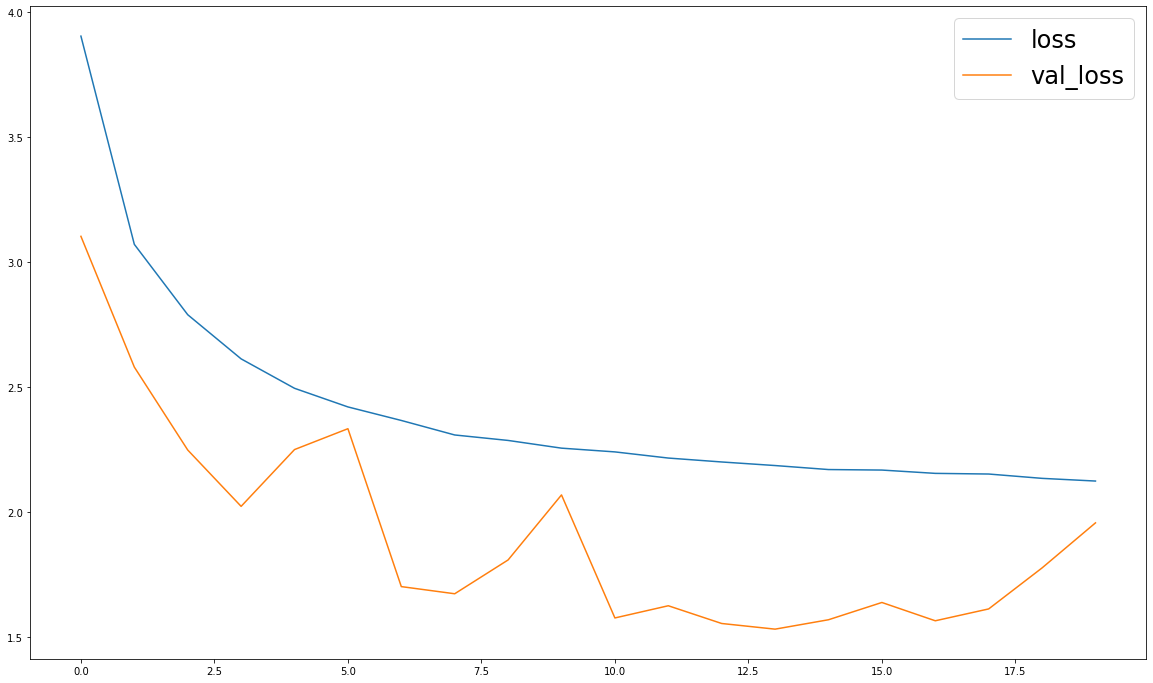

In [ ]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

## Make predictions on the validation dataset

In [ ]:
# Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)
# Generate samples

batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: udacity_driving_datasets/1478900875977309572.jpg

Ground truth boxes:

[[  1   3 149  55 178]
 [  1  46 145  65 172]
 [  1  47 146  62 174]
 [  1  60 149  81 165]
 [  1  61 150  82 167]
 [  1  94 121 272 274]
 [  1 115 144 136 162]
 [  1 238 141 276 165]
 [  1 429 137 479 182]
 [  1 431 140 479 182]
 [  3 362 133 372 146]
 [  3 368 145 385 157]
 [  3 374 141 385 152]
 [  3 395 128 405 169]
 [  3 404 127 415 163]
 [  3 404 128 417 169]]


In [ ]:
# Make a prediction

y_pred = model.predict(batch_images)

Note: the model outputs raw predictions that still need to be decoded and filtered

decode_detections() procedure:

1) In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions (to filter out the majority of the predicted boxes).

2) greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left.

3) the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. 



In [ ]:
# Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.    94.19 118.76 257.58 246.42]
 [  1.     1.    60.14 149.34  81.36 166.47]
 [  1.     0.99  80.42 162.91 227.83 313.71]
 [  1.     0.98   5.66 143.73  57.65 175.25]
 [  1.     0.87 107.55  67.38 300.02 221.12]
 [  1.     0.62 116.81 144.41 137.98 158.3 ]
 [  1.     0.58  63.42 144.94  86.65 162.72]
 [  1.     0.5   15.56 154.3   44.24 177.01]]


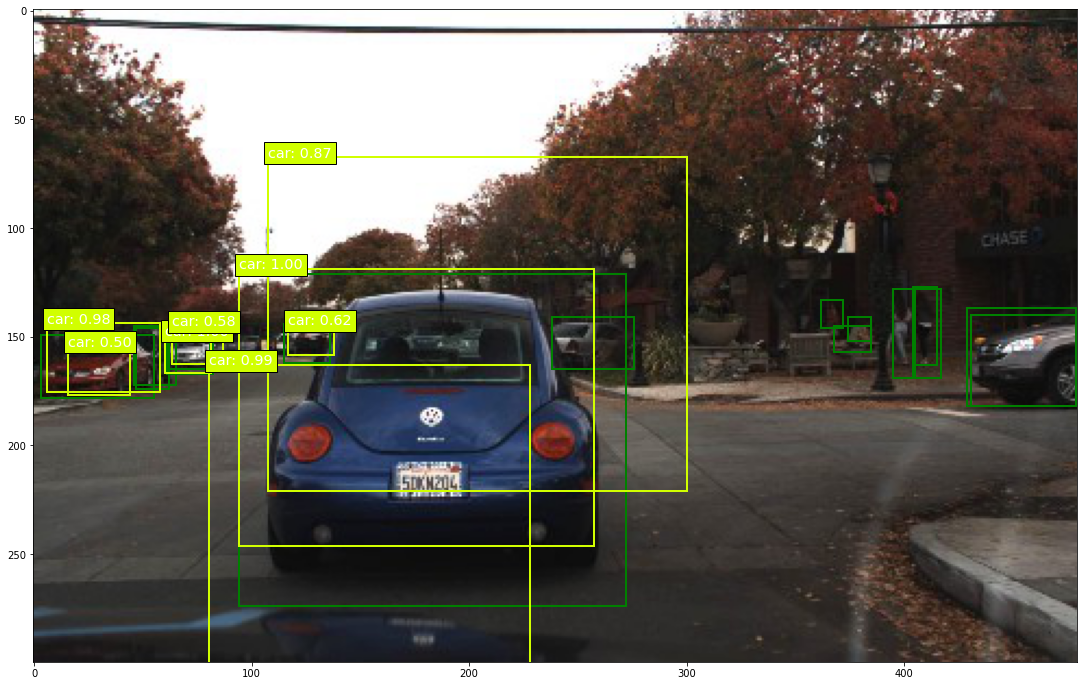

In [ ]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

#**Section 2 : Calculate the mean average percentage (mAP)**


In [ ]:
%tensorflow_version 1.x
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation


#Height, width, channels of the input images
img_height = 300 
img_width = 480 
img_channels = 3 
model_mode = 'inference'
# The current settings to transform the input pixel values to the interval `[-1,1]`.
intensity_mean = 127.5 
intensity_range = 127.5 

# Number of classes in the uploaded dataset
n_classes = 5 

# An explicit list of anchor box scaling factors. If this is passed, 
# it will override the `min_scale` and `max_scale` arguments.
scales = [0.08, 0.16, 0.32, 0.64, 0.96]

aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True #generate two anchor boxes for aspect ratio 1
steps = None # to set the step sizes for the anchor box grids manually; none to set it automaitcally
offsets = None # to set the offsets for the anchor box grids manually;
clip_boxes = False # this option to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # the model is supposed to use coordinates relative to the image size



In [ ]:

# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd7_epoch-14_loss-2.1865_val_loss-1.5318.h5'

# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    mode=model_mode,
                    n_classes=n_classes,
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

model.load_weights(model_path, by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [ ]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.
# DataGenerator provides loading the entire dataset into memory, 
# which reduces the access time for any image
# Another option is loading the HDF5 file that stores the images as uncompressed arrays in a contiguous block of memory, 
# which dramatically speeds up the loading time.

# if we go for calculating the mAP so we can comment out loading the train dataset to save ram memory

##train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='dataset_traffic_train.h5')
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='dataset_traffic_val.h5')

# 2: Parse the image and label lists for the training and validation datasets.

# Images
images_dir = 'udacity_driving_datasets'

# Ground truth
##train_labels_filename = 'labels_train.csv'
val_labels_filename   = 'labels_val.csv'

##train_dataset.parse_csv(images_dir=images_dir,
##                        labels_filename=train_labels_filename,
##                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
##                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

#train_dataset.create_hdf5_dataset(file_path='dataset_traffic_train.h5',
#                                  resize=False,
#                                  variable_image_size=True,
#                                  verbose=True)

#val_dataset.create_hdf5_dataset(file_path='dataset_traffic_val.h5',
#                                resize=False,
#                                variable_image_size=True,
#                                verbose=True)

# Get the number of samples in the training and validations datasets.
##train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

##print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading image IDs: 100%|██████████| 4241/4241 [00:00<00:00, 11035.89it/s]
Number of images in the validation dataset:	  4241


In [ ]:
from eval_utils.average_precision_evaluator import Evaluator
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=val_dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 4241

Matching predictions to ground truth, class 5/5.: 100%|██████████| 380150/380150 [00:14<00:00, 26833.82it/s]
Computing precisions and recalls, class 1/5
Computing precisions and recalls, class 2/5
Computing precisions and recalls, class 3/5
Computing precisions and recalls, class 4/5
Computing precisions and recalls, class 5/5
Computing average precision, class 1/5
Computing average precision, class 2/5
Computing average precision, class 3/5
Computing average precision, class 4/5
Computing average precision, class 5/5


In [ ]:
classes = ['background','car',
           'truck', 'pedestrian', 'bicyclist', 'traffic light']

for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

car           AP    0.408
truck         AP    0.186
pedestrian    AP    0.022
bicyclist     AP    0.013
traffic light AP    0.119

              mAP   0.15
